In [1]:
from functools import partial

import plotly.express
import plotly.io as pio

from rhana.pattern import *
from rhana.spectrum.spectrum import *
from rhana.labeler.unet import *
from rhana.io.kashiwa import *

In [2]:
from rhana.phaser.distance import RHEEDMaskDistancePhaser, DBSCANDistanceCluster

In [9]:
rheed_folder = Path("assets/LastImage")
crop_image_folder = rheed_folder.parent / ( rheed_folder.stem + "_cropped" )

# Load data

## Load rheed and mask from ApplyUNetwithTracking notebook's output csv

In [17]:
df = pd.read_csv(crop_image_folder / "rheed_masks.csv" )

In [21]:
df = df.set_index("crop_path")

In [22]:
df.index = df.index.map(Path)
# extract experiment code
# user might need to modifiy this
ITs = list( map( lambda x: x.stem, df.index ) )
df['IT'] = ITs

In [23]:
df.head()

image_path  \
crop_path                                                              
assets/LastImage_cropped/IT011/IT011.png  assets/LastImage/IT011.png   
assets/LastImage_cropped/IT012/IT012.png  assets/LastImage/IT012.png   
assets/LastImage_cropped/IT030/IT030.png  assets/LastImage/IT030.png   
assets/LastImage_cropped/IT007/IT007.png  assets/LastImage/IT007.png   
assets/LastImage_cropped/IT021/IT021.png  assets/LastImage/IT021.png   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   full_mask_spot  \
crop_path                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
assets/LastImage_cropped/IT011/IT011.png  20361 13 21156 22 21952 27 22750 31 23549 34 24348 36 25134 1 25147 38 25191 1 25194 1 25933 2 25947 38 25991 5 26733 2 26746 40 26791 5 27534 2 27545 42 27592 4 28334 3 28345 42 28393 4 29145 43 29193 4 29932 1 29934 2 29944 45 29993 4 30732 5 30744 45 30793 5 31533 2 31543 46 31593 5 32333 2 32343 46 32395 4 33131 4 33143 46 33195 4 33931 4 33942 47 33995 4 34732 3 34742 47 34795 4 35532 3 35542 47 35595 4 36332 3 36342 46 36395 4 37132 4 37142 47 37195 4 37932 3 37942 47 37995 4 38732 3 38742 47 38795 4 39532 3 39542 47 39595 4 40333 2 40342 47 40395 3 41133 3 41142 47 41195 3 41933 3 4...   
assets/LastImage_cropped/IT012/IT012.png  17960 13 18756 19 19552 26 20350 29 21149 32 21948 34 22747 36 23547 37 24346 38 25145 39 25945 40 26744 41 27544 41 28343 43 29143 43 29943 42 30742 44 31542 44 32342 43 33142 43 33942 43 34742 43 35542 43 36342 43 37142 43 37942 43 38742 43 39542 43 40342 43 41142 44 41943 43 42743 43 43544 41 44344 42 45144 43 45944 43 46745 42 47546 41 48346 41 49147 40 49946 41 50747 39 51548 37 52348 36 53148 34 53948 33 54748 33 55549 30 56349 3 56357 19 57158 16 57960 13 58760 13 59560 11 60361 9 61163 5 61965 2 95563 7 96361 10 97161 10 97960 12 98760 11 99560 11 100361 9 101163 5 117067 5 117866 ...   
assets/LastImage_cropped/IT030/IT030.png                                                                                                                                                                                                                                                                                                                    27570 3 28368 9 29166 14 29964 18 30763 20 31562 22 32361 24 33161 25 33960 27 34760 27 35559 28 36359 28 37160 27 37959 28 38759 28 39559 28 40359 29 41159 28 41959 29 42759 29 43559 29 44359 29 45160 28 45960 27 46762 25 47562 25 48364 22 49164 21 49966 17 50766 14 51566 10 52367 7 164372 1   
assets/LastImage_cropped/IT007/IT007.png  24358 7 25157 12 25957 13 26757 15 27557 17 28357 17 29158 18 29958 18 30758 19 31558 19 32359 20 33159 20 33960 19 34761 18 35562 17 36362 17 37164 14 37964 14 38765 11 39565 5 117112 1 117911 4 118711 7 118822 4 119511 9 119619 8 120311 10 120417 10 121111 10 121217 10 121911 11 1220

In [24]:
img_shape = (200, 400)

In [27]:
# user might need to extend this 

lastentries = {}

for IT, group in df.groupby("IT"):
    # sort group by rheed captured time
    # since we only have the last one here 
    # it is naturely the last one
    lastentries[IT] = group.iloc[-1]

In [29]:
lastentries.keys()

dict_keys(['IT004', 'IT006', 'IT007', 'IT008', 'IT009', 'IT010', 'IT011', 'IT012', 'IT013', 'IT014', 'IT015', 'IT016', 'IT017', 'IT018', 'IT020', 'IT021', 'IT022', 'IT023', 'IT024', 'IT025', 'IT027', 'IT028', 'IT029', 'IT030'])

## Load experimental config

In [32]:
from rhana.io.kashiwa import kashiwa_config, cali_exp_pixel_real, exp_voltage, hv2wl

In [34]:
configs = {}

# load experimental setup from the handy python file
# user could just use RheedConfig to create it 
for IT in lastentries.keys():
    voltage = exp_voltage[IT]
    pixel_real = cali_exp_pixel_real[IT]
    wave_length = hv2wl(voltage)
    config = dict(kashiwa_config)
    config['pixel_real'] = cali_exp_pixel_real[IT]
    config = RheedConfig(**config)
    configs[IT] = config

# Phase Mapping

## Extract features and periodicity analysis

In [69]:
lastrds = {}

for k, v in lastentries.items():
    rd = Rheed.from_image(v.name, config=configs[k])
    streak_label = rle_decode(v['crop_mask_streak'], img_shape) if not pd.isna(v['crop_mask_streak']) else None
    spot_label = rle_decode(v['crop_mask_spot'], img_shape) if not pd.isna(v['crop_mask_spot']) else None
    
    if streak_label is not None:
        rdm_streak = RheedMask(rd, streak_label)
        rdm_streak.get_regions(with_intensity=False)
        streak_regions = rdm_streak.filter_regions(10)
    else: 
        streak_label = np.zeros(rd.pattern.shape)
        streak_regions = []
    
    if spot_label is not None:
        rdm_spot = RheedMask(rd, spot_label)
        rdm_spot.get_regions(with_intensity=False)
        spot_regions = rdm_spot.filter_regions(10)
    else:
        spot_label = np.zeros(rd.pattern.shape)
        spot_regions = []
    
    # merge both mask since we only care about periodicity here
    rdm = RheedMask(rd, np.logical_or(streak_label, spot_label))
    rdm.regions = streak_regions + spot_regions
    
    rdm.get_regions_collapse()
    rdm.clean_collapse()
    rdm.fit_collapse_peaks(height=0.001, threshold=0.000, prominence=0.001)
    rdm.analyze_peaks_distance_cent(tolerant=0.15, abs_tolerant=7, allow_discontinue=1)
    
    lastrds[k] = rdm

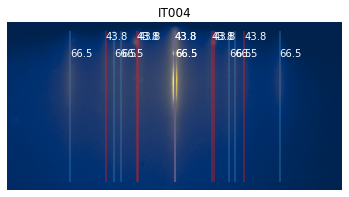

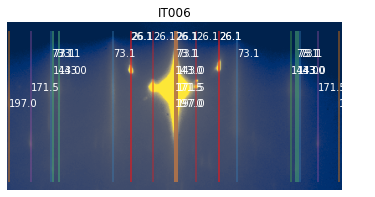

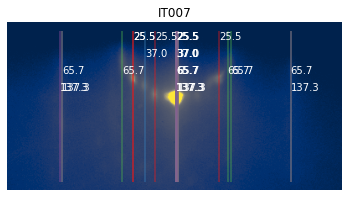

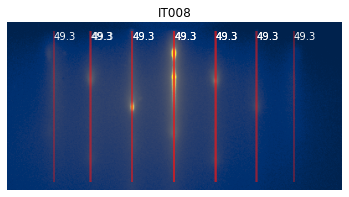

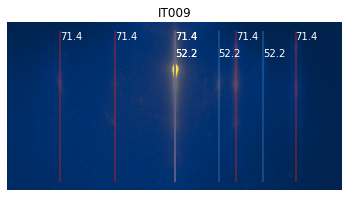

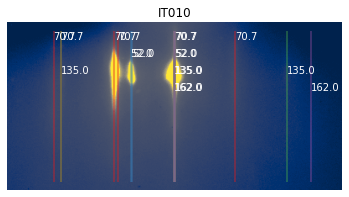

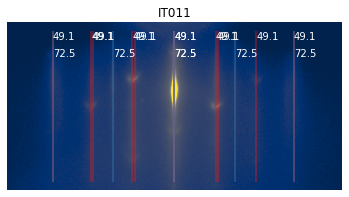

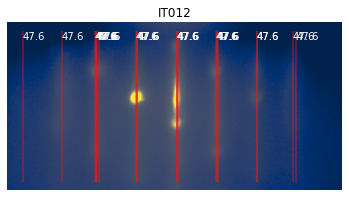

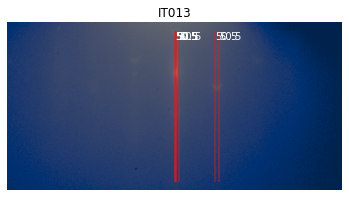

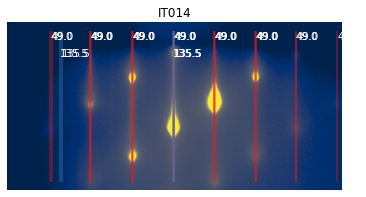

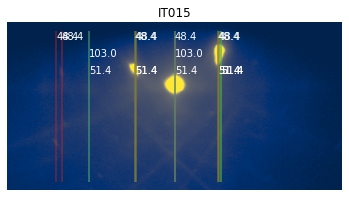

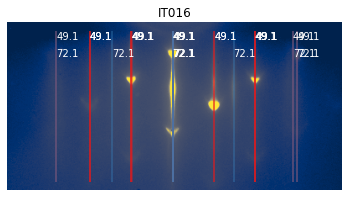

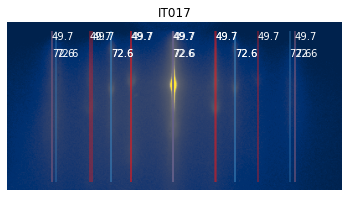

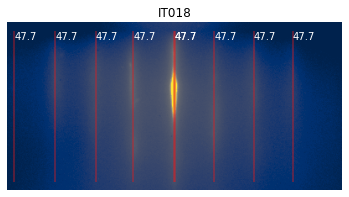

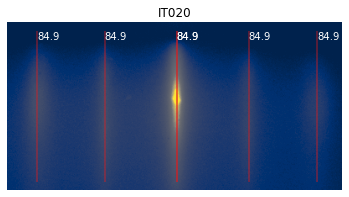

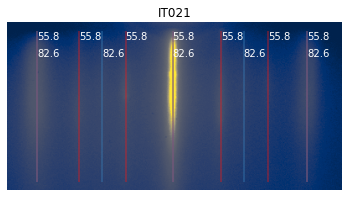

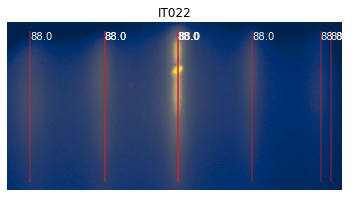

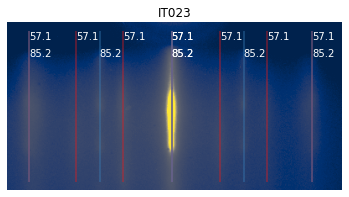

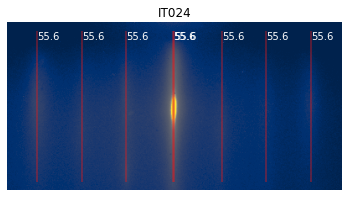

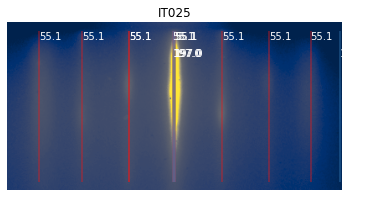

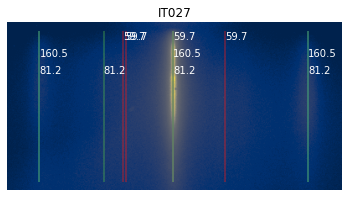

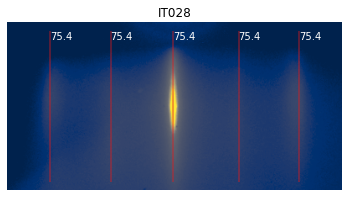

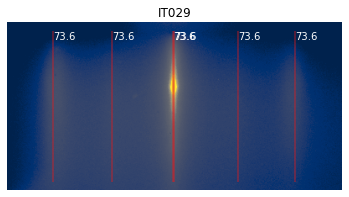

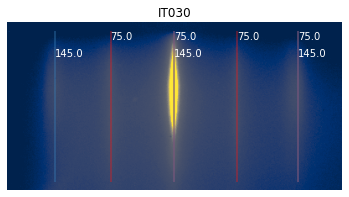

In [84]:
# very cool! right?
for name, rd in lastrds.items():
    rd.plot_peak_dist()
    plt.title(name)
    plt.show()

(None, <AxesSubplot:>)

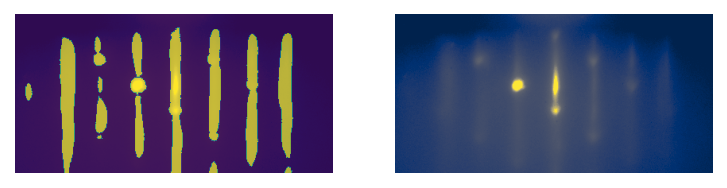

In [98]:
exp_code = 'IT012'
fig, axs = plt.subplots(1, 2, dpi=150)
lastrds[exp_code].plot_pattern_masks(ax=axs[0])
lastrds[exp_code].rd.plot_pattern(ax=axs[1])

## Clustering

In [88]:
# remove bad boy based on sample quality. Not cherry picking 
lastrds.pop("IT015")
lastrds.pop("IT006")

In [89]:
# the convert_dist convert the peak distance from pixel space to G space using the experiment config value
phaser = RHEEDMaskDistancePhaser(list(lastrds.values()), convert_dist=True)

In [90]:
# you can play with eps. The eps work on G now
phaser.run_cluster(eps=1, min_samples=1)

In [99]:
# for debug
# phaser.get_intensity_map()

In [100]:
# check the extracted periodicity from clustering
# if too much or too weird then please go bad and set parameters to a reasonable value
names = list(lastrds.keys())
print("name", "pixel", "G", sep="\t")

for didx, d in phaser.all_peak_dists:
    name = names[didx[0]]
    rd = lastrds[name]
    print( name, round(rd.collapses_peaks_flatten_ana_res[didx[1]].avg_dist, 3), round(d, 3), sep="\t" )

name	pixel	G
IT004	43.833	14.023
IT004	66.5	21.271
IT007	25.5	7.232
IT007	37.0	10.493
IT007	65.7	18.628
IT007	137.333	38.902
IT008	49.333	13.99
IT009	71.375	20.236
IT009	52.25	14.816
IT010	70.7	20.045
IT010	52.0	14.745
IT010	135.0	38.243
IT010	162.0	45.867
IT011	49.111	13.927
IT011	72.5	20.555
IT012	47.633	13.508
IT013	50.5	14.32
IT014	49.044	13.908
IT014	135.5	38.384
IT016	49.135	13.933
IT016	72.1	20.442
IT017	49.741	14.105
IT017	72.562	20.573
IT018	47.738	13.537
IT020	84.875	20.362
IT021	55.778	13.384
IT021	82.625	19.822
IT022	88.0	21.111
IT023	57.111	13.704
IT023	85.25	20.452
IT024	55.556	13.33
IT025	55.071	13.214
IT025	197.0	47.191
IT027	59.667	14.317
IT027	160.5	38.471
IT027	81.167	19.473
IT028	75.375	20.62
IT029	73.625	20.142
IT030	75.0	20.518
IT030	145.0	39.631


## Visualization

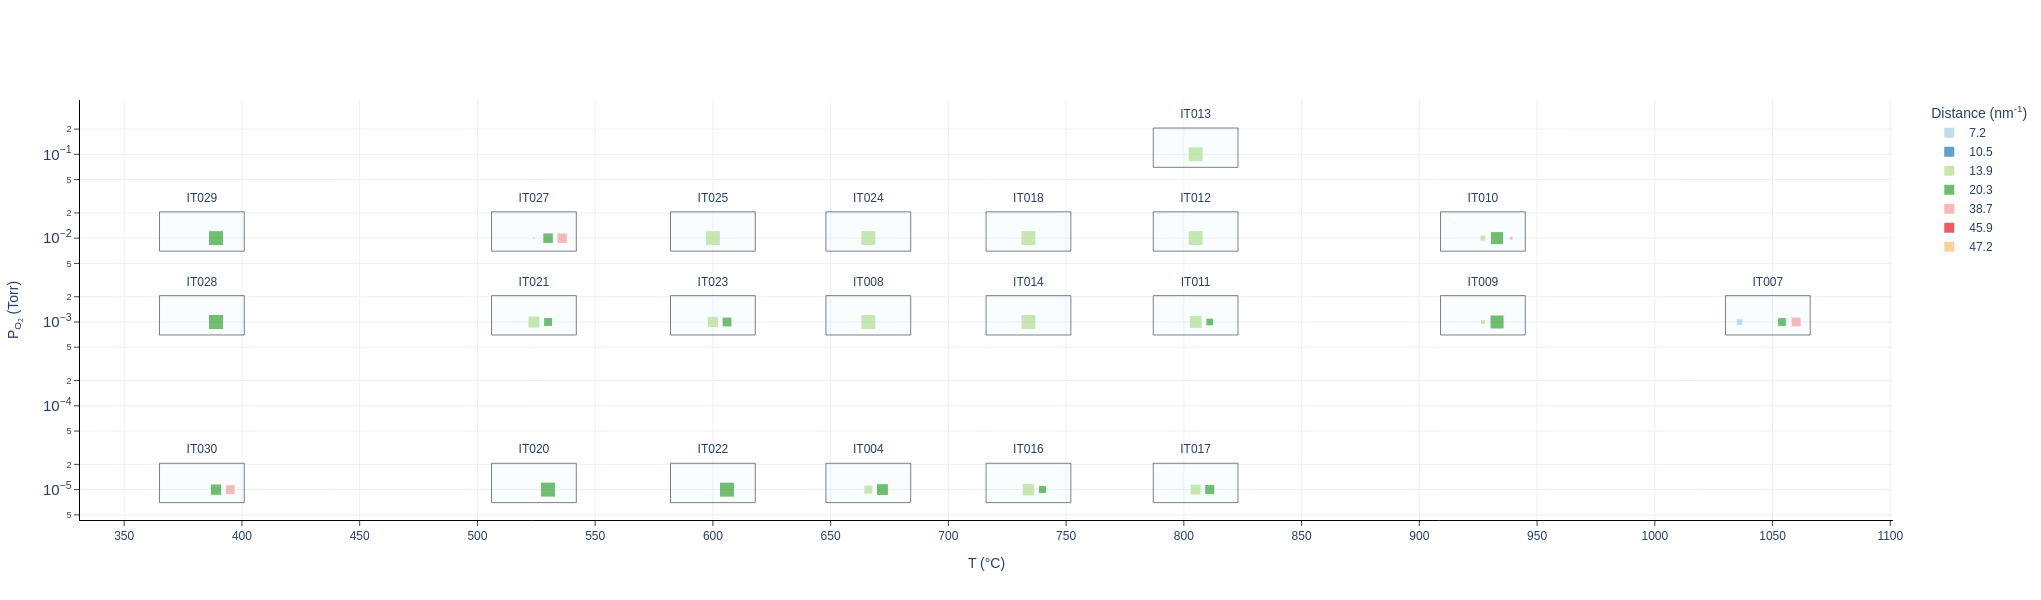

In [105]:
# load the experiment condition for each rheed sequence
x = [ cali_exp_cons[k][1] for k in lastrds.keys() ] 
y = [ cali_exp_cons[k][0] for k in lastrds.keys() ] 

name = list(lastrds.keys())

# looks similar to the one on the publication
fig = phaser.plot_intensity_map(
    x, y, 
    name=name, 
    xlabel="T (°C)", 
    ylabel="P<sub>O<sub>2</sub></sub> (Torr)", 
    log_x=False, 
    log_y=True, 
    x_space=6,
    y_space=0.5,
    max_num_row=5,
    reverse_x=False,
    reverse_y=False,
    scatter_size=15
)

# you can still change the plot
fig.update_layout(
    height = 600,
    width = 1300,    
    legend = dict(title="Distance (nm<sup>-1</sup>)"),
    xaxis = dict(
        tickmode = 'linear',        
        tick0 = 300,
        dtick = 50,
        ticks="outside",
        # mirror = True,
        showline=True,
        linewidth=1, linecolor='black'        
    ),
    yaxis = dict(
        ticks="outside",
        # mirror = True,       
        showline=True,
        linewidth=1, linecolor='black'        
    )
)

In [ ]:
fig.write_html(rheed_folder/"phase_mapping.html")
fig.write_image(rheed_folder/"phase_mapping.png")

# Plots for the publication
Then by some magic from the elden one, these images were pieced together.

In [80]:
x = [ cali_exp_cons[k][1] for k in lastrds.keys() ] 
y = [ cali_exp_cons[k][0] for k in lastrds.keys() ] 

IT_name = list(lastrds.keys())

In [81]:
pio.templates

Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']

In [50]:
name = [ f"{pexp}-{temp}" for pexp, temp in zip(-np.log10(y).astype(int), x) ]

In [51]:
IT_notaion_lookup = {n1:n2 for n1, n2 in zip(IT_name, name)}

In [52]:
IT_notaion_lookup["IT017"]

'5-805'

In [53]:
import colorlover

In [54]:
n_labels = len(np.unique(phaser.dc.labels))

all_multihotencoding = np.zeros( (len(phaser.rdms), n_labels ) )
all_percentage = np.zeros( (len(phaser.rdms), n_labels ) )

for i, rdm, in enumerate(phaser.rdms):
    all_multihotencoding[i, rdm.cluster_labels_unique] = 1
    all_percentage[i, rdm.cluster_labels_unique] = rdm.group_percent

In [55]:
all_percentage.shape

(24, 6)

In [56]:
colorlover.scales['11']['qual']

{'Paired': ['rgb(166,206,227)',
  'rgb(31,120,180)',
  'rgb(178,223,138)',
  'rgb(51,160,44)',
  'rgb(251,154,153)',
  'rgb(227,26,28)',
  'rgb(253,191,111)',
  'rgb(255,127,0)',
  'rgb(202,178,214)',
  'rgb(106,61,154)',
  'rgb(255,255,153)'],
 'Set3': ['rgb(141,211,199)',
  'rgb(255,255,179)',
  'rgb(190,186,218)',
  'rgb(251,128,114)',
  'rgb(128,177,211)',
  'rgb(253,180,98)',
  'rgb(179,222,105)',
  'rgb(252,205,229)',
  'rgb(217,217,217)',
  'rgb(188,128,189)',
  'rgb(204,235,197)']}

In [57]:
#"set3"
#"Paired"

folder = Path("publication/pie_phase")
folder.mkdir(exist_ok=True)

for i in range(len(all_percentage)):
    fig = go.Figure()
    fig.add_trace(
        go.Pie(
            labels = phaser.dc.mean_dists,
            values=all_percentage[i],
            hoverinfo='label+percent+name',
            direction ='clockwise',
            sort=False,
            textinfo='none',
            marker_colors=colorlover.scales['11']['qual']['Paired'],
            opacity=1,
            showlegend=False,
        ),
    )
#     fig.show()
    fig.update_layout(go.Layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    ))

    fig.write_image(str(folder/f"{name[i]}.png"))
    fig.write_html(str(folder/f"{name[i]}.html"))

In [47]:
fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels = [f"{d:.2f}" for d in phaser.dc.mean_dists],
        values=all_percentage[i],
        hoverinfo='label+percent+name',
        direction ='clockwise',
        sort=False,
        textinfo='none',
        marker_colors=colorlover.scales['11']['qual']['Paired'],
        opacity=1,
        showlegend=True,
#         visible=False,
    ),
)
#     fig.show()
fig.update_layout(go.Layout(
    legend = dict(title="Distance (nm<sup>-1</sup>)"),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
))

fig.write_image(str(folder/f"legend.svg"))
fig.write_image(str(folder/f"legend.png"), scale=4)
fig.write_html(str(folder/f"legend.html"))

In [58]:
save_folder = Path("publication")

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = np.array(x),
        y = np.array(y) * 3,
        text = np.array(name),
        showlegend = False,
        mode = "text"
    )    
)

fig.add_trace(
    go.Scatter(
        x = np.array(x),
        y = np.array(y),
        showlegend = False,
        mode = "markers"
    )    
)

fig.update_yaxes(title="P<sub>O<sub>2</sub></sub> (Torr)", type='log', exponentformat="power", range=(-6, 0))
fig.update_xaxes(dtick=50, title="T (°C)", range=(350, 1120))

fig.update_layout(
    height=600, width=1000,
    legend = dict(title="Distance (Pixel)"),
    template="plotly_white",
    
    xaxis = dict(
        tickmode = 'linear',        
        tick0 = 300,
        dtick = 50,
        ticks="outside",
#         mirror = True,
        showline=True,
        linewidth=1, linecolor='black'        
    ),
    yaxis = dict(
        ticks="outside",
#         mirror = True,       
        showline=True,
        linewidth=1, linecolor='black'        
    )
)

if False:
    # no xrd overlay since the new XRD is not clear
    for i in range(1, 1+len(xrd_overlay.values())):
        color = plotly.express.colors.qualitative.Dark2[i]
        color = color.replace("rgb", "rgba")
        color = color[:-1] + ", 0.1)"

        fig.add_trace(
            go.Scatter(
                showlegend=False,
                x=xrd_overlay[f'line{i}']['x'],
                y=xrd_overlay[f'line{i}']['y'],
    #             fill='tonexty',
    #             fillcolor=color,
    #             mode="none"
                line={"color":"black", "width":1, "dash":"dash"},
                opacity=0.8,
                mode="lines",
            )) # fill down to xaxis


# , height=581, width=1325
fig.write_image(str(save_folder/f"phasemapping_backbone.svg"))
fig.write_image(str(save_folder/f"phasemapping_backbone.png"), scale=2)
fig.write_html(str(save_folder/f"phasemapping_backbone.html"))

fig
